# First e-/gamma only run
## Run Details:
- Dataset: pointnet splits with muons removed
- Test Goals: determine if e/gamma discrimination could be improved in a modular framework
- Results Summary: strong memorization of the dataset suggests that either the network is overparametrized for this task, or a larger dataset is required.

In [2]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
import itertools
from tqdm import tqdm
from repeating_classifier_training_utils import *

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# The raw code for this IPython notebook is by default hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Set Run Directories Here

In [32]:
dump_dir = '/home/cmacdonald/CNN/dumps/'

path_1 = os.path.join(dump_dir,'20200717_183009_no_muons')
preferred_run_idx = 0
paths = list([path_1])
dsets=['no_muons'] #specify 'vetoed' or 'no_veto' for each run
run_names=['Run 1']

npz_path = os.path.join(os.getcwd(),'Index_Storage')
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

## Plot Training History

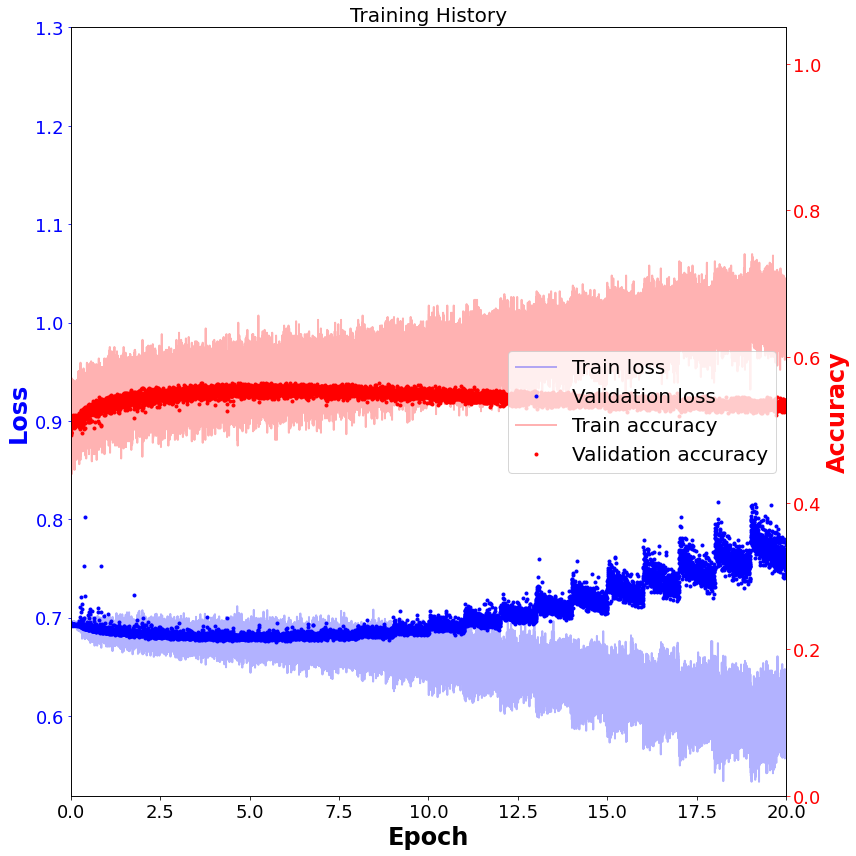

In [35]:
fig = disp_multiple_learn_hist(paths,losslim=1.3,titles=['Training History'],leg_font=20, title_font=20)

## Plot Confusion Matrices

In [18]:
test_output = [load_test_output(os.path.join(loc,'test_validation_iteration_dump.npz'),npz_path,dset=dsets[i]) for i,loc in enumerate(paths)]

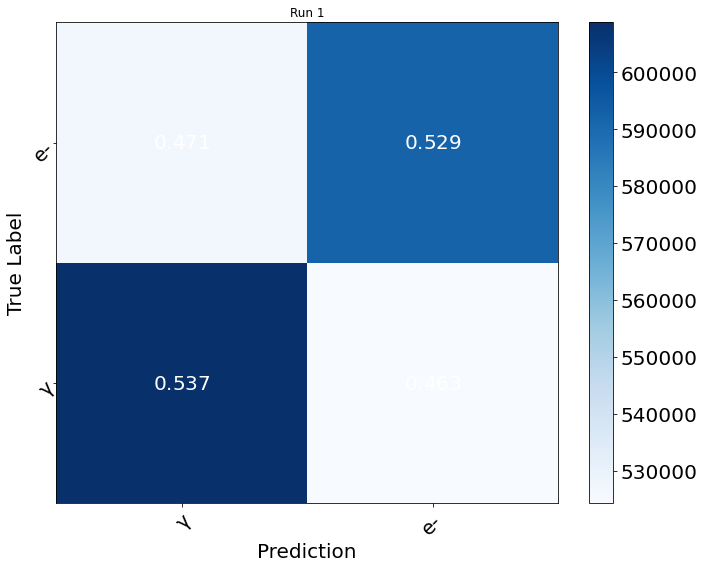

In [28]:
fig = plot_multiple_confusion_matrix([output['filtered_labels'] for output in test_output], [output['filtered_predictions'] for output in test_output],
                               ['\u03B3','e-'],titles=run_names)

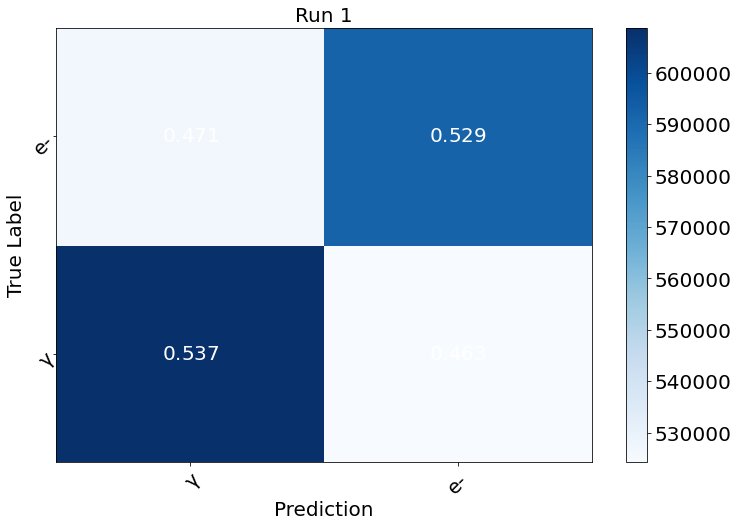

<Figure size 432x288 with 0 Axes>

In [29]:
preferred_run=test_output[preferred_run_idx]
plot_confusion_matrix(preferred_run['filtered_labels'],preferred_run['filtered_predictions'],['\u03B3','e-'],title=run_names[preferred_run_idx])
plt.savefig(os.path.join(os.getcwd(),'plot_images/resnet_confusion_matrix.pdf'))

## ROC Curves

In [33]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['filtered_softmaxes'],output['filtered_labels'],
                                'rejection',softmax_index_dict,"e","gamma",energies=output['filtered_energies'],) for output in test_output]
                            )

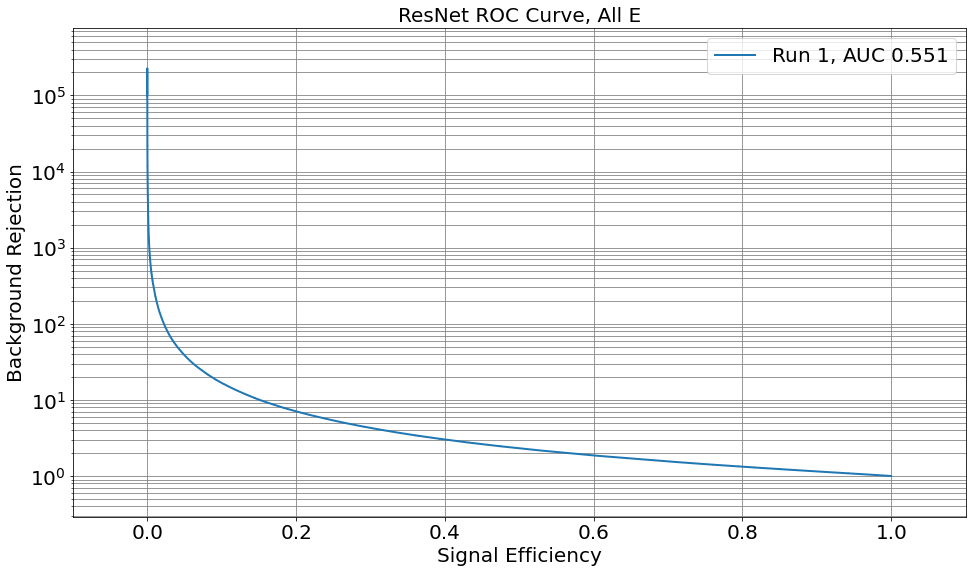

In [34]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "gamma"], 
                                plot_labels=run_names,
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, All E',annotate=False)

In [26]:
# Load the fiTQun results

# File paths for fiTQun results
fiTQun_e_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_e-.npz"
fiTQun_mu_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_mu-.npz"
fiTQun_gamma_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_gamma.npz"

# Load fiTQun results
f_e = np.load(fiTQun_e_path, allow_pickle=True)
f_mu = np.load(fiTQun_mu_path, allow_pickle=True)
f_gamma = np.load(fiTQun_gamma_path, allow_pickle=True)

fq_filename_original = (f_gamma['filename'],f_e['filename'],f_mu['filename'])
fq_eventids_original = ( f_gamma['eventid'],f_e['eventid'], f_mu['eventid'])
fq_flag_original = (f_gamma['flag'] ,f_e['flag'],f_mu['flag'])
fq_nll_original = (f_gamma['nLL'],f_e['nLL'],f_mu['nLL'])
fq_mom_original = (f_gamma['momentum'],f_e['momentum'],f_mu['momentum'])

n_events = int(reduce(lambda x,y : x+y, list(map(lambda x : x.shape[0],fq_filename_original))))

fq_rootfiles = np.empty(n_events,dtype=object)
fq_eventids = np.zeros(n_events)
fq_flag = np.empty((n_events,2))
fq_nll = np.empty((n_events,2))
fq_mom = np.empty((n_events, 2))

fq_mapping_indices = np.load(os.path.join(npz_path,'fq_mapping_idxs.npz'),allow_pickle=True)['arr_0']

filtered_indices = np.load("/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz", allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']
f = h5py.File("/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5", "r")

original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])
filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]
original_labels = np.array(f['labels'])
filtered_labels = original_labels[test_filtered_indices]
fq_failed_idxs = np.load(os.path.join(npz_path,'fq_failed_idxs.npz'), allow_pickle = True)['failed_indices_pointing_to_h5_test_set'].astype(int)
sfiltered_labels = np.delete(filtered_labels, fq_failed_idxs)
sfiltered_eventids = np.delete(filtered_eventids, fq_failed_idxs).astype(int)
sfiltered_rootfiles = np.delete(filtered_rootfiles , fq_failed_idxs)

pbar = ProgressBar(widgets=['Arranging FiTQun Data. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=n_events)
pbar.start()
for i,ptype in enumerate(sfiltered_labels):
    fq_rootfiles[i] = str(fq_filename_original[ptype][fq_mapping_indices[i]])
    fq_eventids[i] = fq_eventids_original[ptype][fq_mapping_indices[i]]
    fq_flag[i] = fq_flag_original[ptype][fq_mapping_indices[i]]
    fq_nll[i] = fq_nll_original[ptype][fq_mapping_indices[i]]
    fq_mom[i] = fq_mom_original[ptype][fq_mapping_indices[i]]
    pbar.update(i)
fq_scores = np.zeros((fq_nll.shape[0],3))
fq_scores[:,0] = fq_nll[:,1] - fq_nll[:,0]
fq_scores[:,1] = fq_nll[:,1] - fq_nll[:,0]
fq_scores[:,2] = fq_nll[:,0] - fq_nll[:,1]
fq_labels = sfiltered_labels
pbar.finish()

pbar = ProgressBar(widgets=['Verification Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(sfiltered_rootfiles))
pbar.start()
for i in range(len(sfiltered_rootfiles)):
    assert re.sub('_fiTQun','',fq_rootfiles[i].split('/')[-1]) == sfiltered_rootfiles[i].split('/')[-1], print(fq_rootfiles[i])
    assert fq_eventids[i] -1 == sfiltered_eventids[i]
    pbar.update(i)
pbar.finish()
assert len(sfiltered_rootfiles) == fq_rootfiles.shape[0]
print("Success! We now have a FiTQun output set in the same order as the h5 test set")

fq_scores_wflagged = fq_scores
fq_labels_wflagged = fq_labels

flagged_idxs = np.load(os.path.join(npz_path, 'fq_flagged_idxs.npz'))['arr_0']
fq_rootfiles = np.delete(fq_rootfiles, flagged_idxs)
fq_eventids = np.delete(fq_eventids, flagged_idxs)
fq_flag = np.delete(fq_flag, flagged_idxs,0)
fq_nll = np.delete(fq_nll, flagged_idxs,0)
fq_scores = np.delete(fq_scores, flagged_idxs,0)
fq_labels = np.delete(fq_labels, flagged_idxs)
fq_mom = np.delete(fq_mom, flagged_idxs, 0)

if fq_dset=='vetoed':
    failed_idxs = np.load(os.path.join(npz_path, 'fq_failed_idxs.npz'))['failed_indices_pointing_to_h5_test_set']
    odveto = np.array(h5py.File('/fast_scratch/WatChMaL/data/IWCDmPMT_4pm_full_tank_ODveto.h5','r')['veto'])
    odveto_mapping_idxs = np.load(os.path.join(os.getcwd(), 'Index_Storage/od_veto_mapping_idxs.npz'))['mapping_idxs_full_set'].astype(int)    
    odveto_mapping_idxs = np.delete(odveto_mapping_idxs, failed_idxs)
    odveto_mapping_idxs = np.delete(odveto_mapping_idxs, flagged_idxs)
    
    odveto=odveto[odveto_mapping_idxs]
    
    assert odveto.shape[0] == fq_rootfiles.shape[0]
    vetoed_idxs = np.where(odveto==1)[0]
    
    fq_rootfiles = np.delete(fq_rootfiles, vetoed_idxs)
    fq_eventids = np.delete(fq_eventids, vetoed_idxs)
    fq_flag = np.delete(fq_flag, vetoed_idxs,0)
    fq_nll = np.delete(fq_nll, vetoed_idxs,0)
    fq_scores = np.delete(fq_scores, vetoed_idxs,0)
    fq_labels = np.delete(fq_labels, vetoed_idxs)
    fq_mom = np.delete(fq_mom, vetoed_idxs, 0)

Arranging FiTQun Data. Progress: 100% [0000000000000000000000000] Time: 0:00:18
Verification Progress: 100% [00000000000000000000000000000000000] Time: 0:00:17


Success! We now have a FiTQun output set in the same order as the h5 test set


/home/cmacdonald/.local/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


In [ ]:
collapsed_sm_1, collapsed_labels_1 = collapse_test_output(preferred_run['filtered_softmaxes'],
                                                                 preferred_run['filtered_labels'],
                                                                 softmax_index_dict, ignore_type="gamma")
fprs, tprs, thresholds = zip(*[prep_roc_data(preferred_run['filtered_softmaxes'],preferred_run['filtered_labels'],
                                'rejection',softmax_index_dict,"e","mu"),
                                prep_roc_data(collapsed_sm_1,collapsed_labels_1, 'rejection',softmax_index_dict, "e","mu"),
                                prep_roc_data(fq_scores,fq_labels,'rejection',softmax_index_dict,"e","mu")
                              ]
                            )

In [ ]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "mu"],['e','mu'],['e','mu']], 
                                plot_labels = [f'{run_names[preferred_run_idx]}', f'{run_names[preferred_run_idx]} (e-/\u03B3 Combined Discriminant)','FiTQun'],
                                png_name = 'overlaid_roc',title='ResNet-FiTQun ROC Curve Comparison',annotate=False,
                                linestyle=('dashdot','-','--'), xlabel='e- Signal Efficiency',ylabel='\u03BC- Background Rejection')
# plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison.pdf'))

In [ ]:
fractions, tprs, fprs, thresholds = zip(*[prep_roc_data(preferred_run['filtered_softmaxes'],preferred_run['filtered_labels'],
                                'fraction',softmax_index_dict,"e","mu"),
                                prep_roc_data(preferred_run['filtered_softmaxes'],preferred_run['filtered_labels'],
                                'fraction',softmax_index_dict,"e","gamma"),
                                prep_roc_data(collapsed_sm_1,collapsed_labels_1, 'fraction',
                                              softmax_index_dict, "e","mu")],
                                prep_roc_data(fq_scores,fq_labels,'fraction',softmax_index_dict,"e","mu")
                            )

In [ ]:
roc_metrics = plot_multiple_ROC((fractions, tprs, fprs, thresholds),'fraction', [["e", "mu"],['e','gamma'],['e','mu'],['e','mu']], 
                                plot_labels = ['e Eff. vs Muon Rej.', 'e Eff. vs Gamma Rej.', 'e/Gamma Eff. vs Muon Rej. \n (e/mu events)','FiTQun e Eff. vs Muon Rej.'],
                                png_name = 'overlaid_roc',title='Repeat Run ROC Curves',annotate=False,linestyle=(':','-','--','dashdot'),
                                leg_loc='lower left')
plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison_fraction.pdf'))

## Signal Purity vs Energy At Fixed Efficiency

In [ ]:
GAMMA_THRESHOLD = 1.55
ELECTRON_THRESHOLD = 0.775
MUON_THRESHOLD = 160.26
shifted_energies = []

shifted_energies = np.zeros(preferred_run['filtered_labels'].shape[0])
g_idxs = np.where(preferred_run['filtered_labels']==0)[0]
e_idxs = np.where(preferred_run['filtered_labels']==1)[0]
m_idxs = np.where(preferred_run['filtered_labels']==2)[0]
shifted_energies[g_idxs] = np.squeeze(preferred_run['filtered_energies'][g_idxs] - GAMMA_THRESHOLD)
shifted_energies[e_idxs] = np.squeeze(preferred_run['filtered_energies'][e_idxs] - ELECTRON_THRESHOLD)
shifted_energies[m_idxs] = np.squeeze(preferred_run['filtered_energies'][m_idxs] - MUON_THRESHOLD)

In [ ]:
collapsed_sm, collapsed_labels = collapse_test_output(preferred_run['filtered_softmaxes'],
                                                                 preferred_run['filtered_labels'],
                                                                 softmax_index_dict)

In [ ]:
shifted_energies.shape

In [ ]:
preferred_run['filtered_labels'].shape

In [ ]:
fq_scores.shape

In [ ]:
##Binning in Energy
scores = [fq_scores, preferred_run['filtered_softmaxes'], fq_scores, collapsed_sm, fq_scores, collapsed_sm, -fq_scores, preferred_run['filtered_softmaxes']]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [shifted_energies,shifted_energies,np.clip(fq_mom[:,0], 0, 1000),shifted_energies]
feature_labels = ['Energy above Cherenkov Threshold (MeV)', 'Energy above Cherenkov Threshold (MeV)','FiTQun Reconstructed Electron Momentum (MeV)','Energy above Cherenkov Threshold (MeV)']
title_notes = ['',', Combined ResNet Discriminant',', Combined ResNet Discriminant','']
pos_labels = ['e','e','e','e']
neg_labels = ['mu','mu','mu','gamma']
img_names=['rejection_vs_e.pdf','rejection_vs_e_combined_disc.pdf', 'rejection_vs_recon_e_combined_disc.pdf', 'e_gamma_rejection_vs_e.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i]))

In [ ]:
#Binning in d-to-wall
d_to_wall_incl_all = np.load('dist_to_wall.npz', allow_pickle=True)['test_d_to_wall']
fq_failed_idxs = np.load('Index_Storage/fq_failed_idxs.npz', allow_pickle=True)['failed_indices_pointing_to_h5_test_set']
fq_flagged_idxs = np.load('Index_Storage/fq_flagged_idxs.npz', allow_pickle=True)['arr_0']
d_to_wall_incl_flagged = np.delete(d_to_wall_incl_all, fq_failed_idxs)
d_to_wall = np.delete(d_to_wall_incl_flagged, fq_flagged_idxs)
if fq_dset=='vetoed':d_to_wall = np.delete(d_to_wall, vetoed_idxs)

scores = [fq_scores, preferred_run['filtered_softmaxes'], fq_scores, collapsed_sm, fq_scores, preferred_run['filtered_softmaxes'] ]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [d_to_wall,d_to_wall,d_to_wall]
feature_labels = ['Distance to Wall Along Particle Trajectory (cm)','Distance to Wall Along Particle Trajectory (cm)','Distance to Wall Along Particle Trajectory (cm)']
title_notes = [None,', Combined ResNet Discriminant','']
pos_labels = ['e','e','gamma']
neg_labels = ['mu','mu','e']
img_names=['rejection_vs_dtowall.pdf','rejection_vs_dtowall_combined_disc.pdf', 'e_gamma_rejection_vs_dtowall.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i]))

In [ ]:
#Binning in origin radius squared
test_radius_incl_all = np.load('event_radii.npz')['test_radii']
test_radius_incl_flagged = np.delete(test_radius_incl_all, fq_failed_idxs)
test_radius = np.delete(test_radius_incl_flagged, fq_flagged_idxs)
if fq_dset=='vetoed': test_radius = np.delete(test_radius, vetoed_idxs)

scores = [fq_scores, preferred_run['filtered_softmaxes'], fq_scores, collapsed_sm, -fq_scores, preferred_run['filtered_softmaxes'] ]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [test_radius**2,test_radius**2,test_radius**2]
feature_labels = ['Radius Squared of Event Origin (cm^2)' for _ in range(3)]
title_notes = [None,', Combined ResNet Discriminant',None]
pos_labels = ['e','e','e']
neg_labels = ['mu','mu','gamma']
img_names=['rejection_vs_radius.pdf','rejection_vs_radius_combined_disc.pdf', 'e_gamma_rejection_vs_radius.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
    plt.axvline(x=371**2)
    plt.axvline(x=321**2)
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i]))

In [ ]:
#rest masses in MeV/c^2
E_REST_MASS = 0.510998
MUON_REST_MASS = 105.658
GAMMA_REST_MASS = 0
rest_masses = {softmax_index_dict['gamma']:GAMMA_REST_MASS, softmax_index_dict['e']:E_REST_MASS, softmax_index_dict['mu']:MUON_REST_MASS}
true_momentum = np.ones_like(preferred_run['filtered_energies'])
pbar = ProgressBar(widgets=['Find True Momentum: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
        ' ', ETA()], maxval=preferred_run['filtered_labels'].shape[0])
pbar.start()
for i, energy in enumerate(preferred_run['filtered_energies']):
    #true momentum in units of MeV/c
    pbar.update(i)
    true_momentum[i] = np.sqrt(energy**2 - rest_masses[preferred_run['filtered_labels'][i]]**2)
pbar.finish()

## Assessing FiTQun Using Reconstructed Momentum-Determined Thresholds

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(20,10))
muon_idxs=np.where(fq_labels==2)[0]
electron_idxs=np.where(fq_labels==1)[0]
for i, xrange in enumerate([None, [0,1250]]):
    ax=axes[i]
    ax.hist(true_momentum[electron_idxs],bins=90,range=xrange,histtype=u'step',label='True, e- Events')
    ax.hist(true_momentum[muon_idxs],bins=90,range=xrange,histtype=u'step',label='True, \u03BC- Events')
    ax.hist(fq_mom[muon_idxs,0],bins=900,range=xrange,histtype=u'step',label='FiTQun e- Recons., \u03BC- Events')
    ax.hist(fq_mom[electron_idxs,0],bins=900,range=xrange,histtype=u'step',label='FiTQun e- Recons., e- Events')
    ax.hist(fq_mom[muon_idxs,1],bins=900,range=xrange,histtype=u'step',label='FiTQun \u03BC- Recons., \u03BC- Events')
    ax.hist(fq_mom[electron_idxs,1],bins=900,range=xrange,histtype=u'step',label='FiTQun \u03BC- Recons., e- Events') 
    ax.set_xlabel('Momentum (MeV/c)')
    ax.set_ylabel('Number of Events')
    ax.legend(loc='lower center')
    ax.set_yscale('log')
    title = f'Momentum Distributions in Test Set, {xrange[0]} < p < {xrange[1]}' if xrange is not None else 'Momentum Distributions in Test Set'
    ax.set_title(title)

In [ ]:
recon_mom_by_label = np.ones_like(fq_mom[:,0])
recon_mom_by_label[muon_idxs] = fq_mom[muon_idxs, 1]
recon_mom_by_label[electron_idxs] = fq_mom[electron_idxs, 0]

In [ ]:
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

odv_file = h5py.File('/fast_scratch/WatChMaL/data/IWCDmPMT_4pm_full_tank_ODveto.h5','r')
odv_mapping_idxs = np.load(os.path.join(npz_path, 'od_veto_mapping_idxs.npz'),allow_pickle=True)['mapping_idxs_full_set']
od_veto = np.array(odv_file['veto'])[odv_mapping_idxs]


original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")
original_positions=np.array(f['positions'])
test_positions = original_positions[test_filtered_indices]
f.close()

failed_idxs = np.load(os.path.join(npz_path, 'fq_failed_idxs.npz'),allow_pickle=True)['failed_indices_pointing_to_h5_test_set'].astype(int)
flagged_idxs = np.load(os.path.join(npz_path, 'fq_flagged_idxs.npz'),allow_pickle=True)['arr_0'].astype(int)

test_positions = np.delete(test_positions, failed_idxs,0)
test_positions = np.delete(test_positions, flagged_idxs,0)

if fq_dset=='vetoed': test_positions = np.delete(test_positions, vetoed_idxs,0)

od_veto = np.delete(od_veto, failed_idxs)
od_veto = np.delete(od_veto, flagged_idxs)

if fq_dset=='vetoed': od_veto = np.delete(od_veto, vetoed_idxs)

test_positions = np.squeeze(test_positions, axis=1)

In [ ]:
test_zs = test_positions[:,1]
origin_to_wall = np.array([np.min((371-test_radius[i],521 - test_zs[i], test_zs[i] + 521)) for i in range(test_zs.shape[0])])
origin_to_wall_cut_remove_idxs = np.where(origin_to_wall < 50)[0]
e_specific_cut_remove_idxs = np.where((fq_labels==1)&(d_to_wall < 0.63 * np.log(true_momentum) - 2))[0]
muon_specific_veto_remove_idxs = np.where((fq_labels==2)&(od_veto==1))[0]
remove_idxs = np.concatenate((origin_to_wall_cut_remove_idxs, e_specific_cut_remove_idxs,muon_specific_veto_remove_idxs))

In [ ]:
official_scores = np.delete(fq_scores, remove_idxs,0)
official_labels = np.delete(fq_labels, remove_idxs)
official_true_mom = np.delete(true_momentum, remove_idxs)
official_fq_mom = np.delete(fq_mom[:,0], remove_idxs)

In [ ]:
rn_official_scores = np.delete(preferred_run['filtered_softmaxes'],remove_idxs,0)

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(20,10))
muon_idxs=np.where(official_labels==2)[0]
electron_idxs=np.where(official_labels==1)[0]
for i, xrange in enumerate([None, [0,1250]]):
    ax=axes[i]
    ax.hist(official_true_mom[electron_idxs],bins=90,range=xrange,histtype=u'step',label='True, e- Events')
    ax.hist(official_true_mom[muon_idxs],bins=90,range=xrange,histtype=u'step',label='True, \u03BC- Events')
    ax.hist(official_fq_mom[muon_idxs],bins=900,range=xrange,histtype=u'step',label='FiTQun e- Recons., \u03BC- Events')
    ax.hist(official_fq_mom[electron_idxs],bins=900,range=xrange,histtype=u'step',label='FiTQun e- Recons., e- Events') 
    ax.set_xlabel('Momentum (MeV/c)')
    ax.set_ylabel('Number of Events')
    ax.legend(loc='lower center')
    ax.set_yscale('log')
    title = f'Momentum Distributions in Test Set Post Cut, {xrange[0]} < p < {xrange[1]}' if xrange is not None else 'Momentum Distributions in Test Set Post Cut'
    ax.set_title(title)

In [ ]:
fig,axes  =plt.subplots(1,2,figsize=(18,9))
for i, metric in enumerate(['mu fpr', 'efficiency']):
    plot_fitqun_binned_performance(official_scores[:,1], official_labels, official_true_mom, np.clip(official_fq_mom,0,1160), 0.005, softmax_index_dict, 
                                ax=axes[i],marker='o--',color='r',title_note='',metric=metric,yrange=[0,0.01] if i==0 else None,true_mom_bins=40)
    momentum,thresholds_per_event = plot_fitqun_binned_performance(np.delete(preferred_run['filtered_softmaxes'][:,1] + preferred_run['filtered_softmaxes'][:,0] ,remove_idxs,0), official_labels, official_true_mom, np.clip(official_fq_mom,0,1160), 0.005, softmax_index_dict, 
                                ax=axes[i],marker='*-',color='g',title_note='',metric=metric,yrange=[0,0.01] if i==0 else None,true_mom_bins=40)
    axes[i].legend(['FiTQun','ResNet (P(e-) + P(\u03B3))'])

In [ ]:
_,bins = np.histogram(momentum, bins=80, range=(0,1000))
bins = bins[0:-1]
bin_assignments = np.digitize(momentum, bins)
average_thresh_list = []
for bin_idx in range(len(bins)):
    bin_num = bin_idx + 1 #these are one-indexed for some reason
    this_bin_idxs = np.where(bin_assignments == bin_num)[0]
    average_thresh_list.append(np.mean(thresholds_per_event[this_bin_idxs]))
bin_centers = [(bins[i+1] - bins[i])/2 + bins[i] for i in range(0,len(bins)-1)]
bin_centers.append((1000 - bins[-1])/2 + bins[-1])
plt.plot(bin_centers, average_thresh_list)
plt.xlabel('True Momentum, MeV/c')
plt.ylabel('Operating Point Threshold')

In [ ]:
collapsed_sm_official, collapsed_labels_official = collapse_test_output(rn_official_scores,
                                                                 official_labels,
                                                                 softmax_index_dict, ignore_type="gamma")
rn_fprs, rn_tprs, rn_thresholds = prep_roc_data(rn_official_scores,official_labels,
                                'rejection',softmax_index_dict,"e","mu")
fprs = [rn_fprs]
tprs = [rn_tprs]
thresholds = [rn_thresholds]
fq_official_fprs,fq_official_tprs,fq_official_threshs = prep_roc_data(official_scores, official_labels,'rejection',softmax_index_dict,"e","mu")

fprs.append(fq_official_fprs)
tprs.append(fq_official_tprs)
thresholds.append(fq_official_threshs)

roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "mu"],['e','mu']], 
                                plot_labels = ['ResNet e- Eff. vs Muon Rej.','FiTQun e- Eff. vs Muon Rej.'],
                                png_name = 'overlaid_roc',title='ROC Curves, Official Plot Sample',annotate=False,linestyle=(':','-','--'))

## Plot Classifier Response

In [ ]:
fig=plot_response(preferred_run['filtered_softmaxes'], preferred_run['filtered_labels'], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['lower center', 'lower center', 'upper center',
                                                                                    'upper center'])
plt.savefig(os.path.join(os.getcwd(),'plot_images/resnet_response.pdf'))

In [ ]:
ns,bins = np.histogram(shifted_energies, bins=5)
left_edges = bins[0:-1]
bin_assignments = np.digitize(shifted_energies, left_edges)

In [ ]:
for BIN_NUM in range(1,6):
    bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
    fig = plot_response(preferred_run['filtered_softmaxes'][bin_idxs,:], preferred_run['filtered_labels'][bin_idxs], ['gamma','e','mu'], 
                        softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                        'upper center'])
    a = fig.suptitle(f'Classifier Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(os.getcwd(),f'plot_images/resnet_1d_binned_response_bin{BIN_NUM}.pdf'))

In [ ]:
for i in range(fq_labels.shape[0]):
    assert fq_labels[i] == preferred_run['filtered_labels'][i]
assert fq_labels.shape[0] == preferred_run['filtered_labels'].shape[0]

## Plot Binned Response

In [ ]:
binning_features = [shifted_energies, test_radius**2, d_to_wall]
binning_labels=['Energy above Cherenkov Threshold (MeV)','Radius Squared of Event Origin (cm^2)',
                'Trajectory Distance to Wall (cm)']

In [ ]:
img_names = ['2d_resnet_binned_response_energy.pdf','2d_resnet_binned_response_radius.pdf','2d_resnet_binned_response_dtowall.pdf']
for i in range(len(binning_features)):
    fig = plot_binned_response(preferred_run['filtered_softmaxes'],
            preferred_run['filtered_labels'],
            binning_features[i],           
            binning_labels[i],
            0.8, 30, 30,softmax_index_dict,
            log_scales=[2,6,8,9,11,3,7,10]
            )
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i])) 